# Ghost Vs No Ghost ~ all frequencies: BJH021

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy
import joblib

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
## Prep paths ##

subject = 'BJH021'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

# load
last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(last_away_ecpohs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(last_away_ecpohs.get_annotations_per_epoch()) if  x]

# onlt good epochs
last_away_ecpohs = last_away_ecpohs[good_epochs]

# load behavioral data
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")

## Prep Behavioral Data
last_away_data['trial_numeric'] = last_away_data['trial_numeric'] - 1
last_away_data = last_away_data[last_away_data.index.isin(good_epochs)]

# set info as metadata
last_away_ecpohs.metadata = last_away_data

Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_last_away_events.fif ...


/tmp/ipykernel_8746/870373520.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")


    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_last_away_events-1.fif ...
    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
0 bad epochs dropped
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns


In [4]:
# separate ghost and no ghost trials

ghost_epochs = last_away_ecpohs["TrialType <= 16"]
no_ghost_epochs = last_away_ecpohs["TrialType > 16"]

In [5]:
## Dictionary of electrode locations ##


ROIs = {
    'hc'     :['B3', 'B4', 'B5'],
    'ofc'    :[],
    'amyg'   :[],
    'insula' :[],
    'cing'   :[]
}

hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = []               
insula_list = []
insula_names = []            
cing_list = []
cing_names = []               
pairs_long_name = [ch.split('-') for ch in last_away_ecpohs.info['ch_names']]
bidx = len(last_away_ecpohs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        
hc_list

['B3-B4', 'B4-B5', 'B5-B6']

In [6]:
def MM_compute_TFR(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    TFR.data = np.log(TFR.data)
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(3),keepdims=True)
        bstd = TFR.data[:,:,:,bix].std(axis=(3),keepdims=True)
        TFR.data = (TFR.data - bmean) / bstd
    return TFR

def MM_compute_TFR_ratio(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean

    return TFR

def MM_compute_TFR_logratio(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean
        TFR.data = np.log(TFR.data) 
                                            
    return TFR

def MM_compute_TFR_zlogratio(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean
        TFR.data = np.log(TFR.data) 
        bstd = TFR.data[:,:,:,bix].std(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/ bstd
    return TFR


def stockwell_TFR_ratio(epochs, fmin, fmax, baseline, zscore=True):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_stockwell(epochs,fmin,fmax,return_itc=False,
                                            n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean

    return TFR

### Hippocampus

In [7]:
hc_list

['B3-B4', 'B4-B5', 'B5-B6']

In [8]:
ghost_hc = ghost_epochs.copy().pick_channels(hc_list)
no_ghost_hc = no_ghost_epochs.copy().pick_channels(hc_list)

In [9]:
ghost_hc= ghost_hc.resample(1000)
no_ghost_hc= no_ghost_hc.resample(1000)

In [10]:
ghost_hc.metadata

,trial_numeric,TrialType,sample,sample_before,event
3,8,16,170400,0,1
4,9,7,186100,0,1
5,10,6,198400,0,1
6,14,5,253400,0,1
7,15,11,267800,0,1
...,...,...,...,...,...
171,228,2,2927000,0,1
172,229,4,2937500,0,1
174,231,11,2964600,0,1
175,232,1,2976300,0,1


In [11]:
# random_trials = np.random.randint(low = 0, high = 143, size = 40 )
# ghost_hc_test = ghost_hc['trial_numeric.sample(40)']
# ghost_hc_test


In [12]:
# Set frequencies

freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
n_cycles = np.logspace(np.log10(2), np.log10(30), base = 10, num = 80)

# formulas to check bandwidth and time bin
band_width = (freqs / n_cycles) * 2
time_bin = n_cycles / freqs / np.pi
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)


[  1.           1.06548039   1.13524845   1.20958496   1.28878905
   1.37317945   1.46309577   1.55889984   1.6609772    1.76973863
   1.8856218    2.00909304   2.14064922   2.28081976   2.43016872
   2.5892971    2.75884527   2.93949552   3.13197482   3.33705774
   3.55556956   3.78838962   4.03645484   4.30076345   4.5823791
   4.88243505   5.20213877   5.54277682   5.90571998   6.2924288
   6.70445946   7.14347005   7.61122722   8.10961331   8.64063391
   9.20642595   9.80926626  10.45158079  11.13595433  11.8651409
  12.6420749   13.46988283  14.35189595  15.29166362  16.29296764
  17.35983743  18.49656627  19.70772855  20.99819821  22.37316831
  23.83817199  25.39910467  27.06224782  28.83429423  30.72237491
  32.73408785  34.87752853  37.16132253  39.59466023  42.18733383
  44.94977669  47.89310538  51.02916436  54.37057369  57.93077979
  61.72410955  65.76582801  70.07219975  74.66055437  79.54935622
  84.75827869  90.30828341  96.22170458 102.52233885 109.23554107
 116.38832636

In [13]:


# ghost_TFR = stockwell_TFR_ratio(ghost_hc,fmin = .5,fmax = 150,baseline = (-2,2), zscore=True)
# no_ghost_TFR = stockwell_TFR_ratio(no_ghost_hc,fmin = .5,fmax = 150,baseline = (-2,2), zscore=True)

ghost_TFR = MM_compute_TFR(ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)
no_ghost_TFR = MM_compute_TFR(no_ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   36.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   36.8s finished


Adding metadata with 5 columns
log transforming
z-scoring to baseline
computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Adding metadata with 5 columns


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   12.9s finished


log transforming
z-scoring to baseline


In [14]:
ghost_TFR.crop(tmin = -2, tmax = 2)
no_ghost_TFR.crop(tmin = -2, tmax = 2)

<EpochsTFR | time : [-2.000000, 2.000000], freq : [1.000000, 150.000000], epochs : 44, channels : 3, ~322.4 MB>

In [15]:
ghost_TFR.data.shape

(125, 3, 80, 4001)

/tmp/ipykernel_8746/2315644377.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_8746/2315644377.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


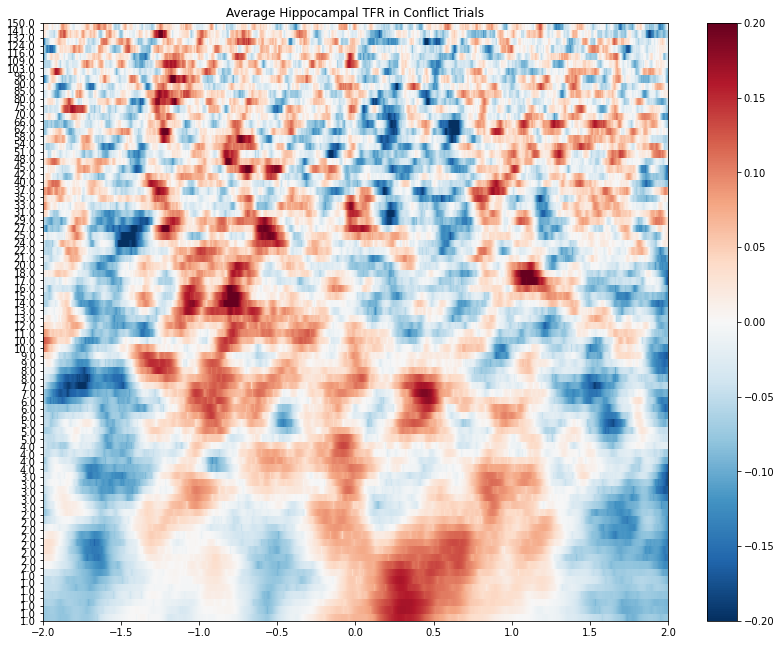

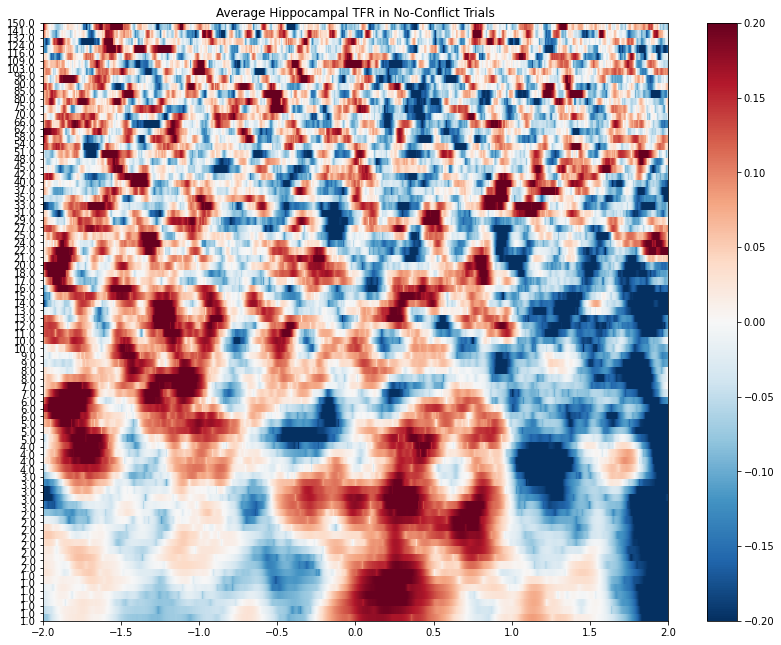

In [16]:
plt.rcParams['figure.figsize'] = [14, 11]
fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Hippocampal TFR in Conflict Trials")
fig.show()
fig.savefig('BJH021_average_hippocampus_conflict.png', dpi=600)

fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Hippocampal TFR in No-Conflict Trials")
fig.show()
fig.savefig('BJH021_average_hippocampus_noconflict.png', dpi=600)



In [ ]:
# true difference matrix
true_diff_matrix = ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0) - no_ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0)


# initialize permuted matrix
permuted_matrix = np.nan * np.ones_like(true_diff_matrix)
permuted_matrices = np.repeat(permuted_matrix[np.newaxis,...], 1000, axis=0)

# get incex vectors
num_ghost_trials = ghost_TFR.data.shape[0]
num_no_ghost_trials = no_ghost_TFR.data.shape[0]
total_trials = num_ghost_trials + num_no_ghost_trials
trial_indices = np.arange(0, total_trials, 1)

# combine all tfrs
all_tfrs = np.concatenate([ghost_TFR.data[:, :, :, :] , no_ghost_TFR.data[:, :, :, :]], axis = 0)

for permute in range(0, 1000):
    
    trial_indices = np.arange(0, total_trials, 1)
    np.random.seed(permute)
    fake_ghost_indices = np.random.choice(a = trial_indices, size=num_ghost_trials, replace = False)
    fake_no_ghost_indicies = np.delete(trial_indices, fake_ghost_indices)


    fake_ghost_tfr = all_tfrs[fake_ghost_indices, :, :, :]
    fake_no_ghost_tfr = all_tfrs[fake_no_ghost_indicies, :, :, :]

    permuted_matrices[permute, :, :] = fake_ghost_tfr.mean(axis = 0).mean(axis = 0) - fake_no_ghost_tfr.mean(axis = 0).mean(axis = 0)


In [ ]:
# create dummy sig matrix
sig_matrix = np.full(true_diff_matrix.shape, False, dtype = 'bool')
pval_matrix = np.nan * np.ones_like(true_diff_matrix)


# find values at the extreme
for y in range(0,80):
    for x in range(0, 4001):

        permuted_dist = np.sort(permuted_matrices[:, y, x])

        if true_diff_matrix[y, x] <= permuted_dist[50] or true_diff_matrix[y, x] >=permuted_dist[950] :
            sig_matrix[y, x] = True
        else:
            sig_matrix[y, x] = False

sig_diff_matrix = np.where(sig_matrix, true_diff_matrix, np.nan)


In [ ]:

fig, ax = plt.subplots()
i1 = ax.imshow(true_diff_matrix, cmap = 'Greys', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
i2 = ax.imshow(sig_diff_matrix, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i2)
ax.set_title("Hippocampus: Sig Difference Matrix")
fig.show()



/tmp/ipykernel_8746/3873617026.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_8746/3873617026.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


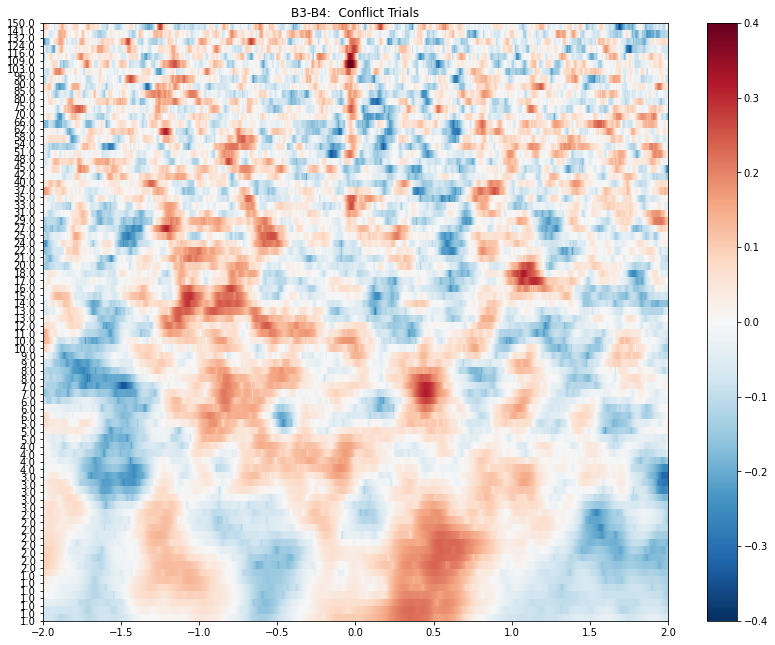

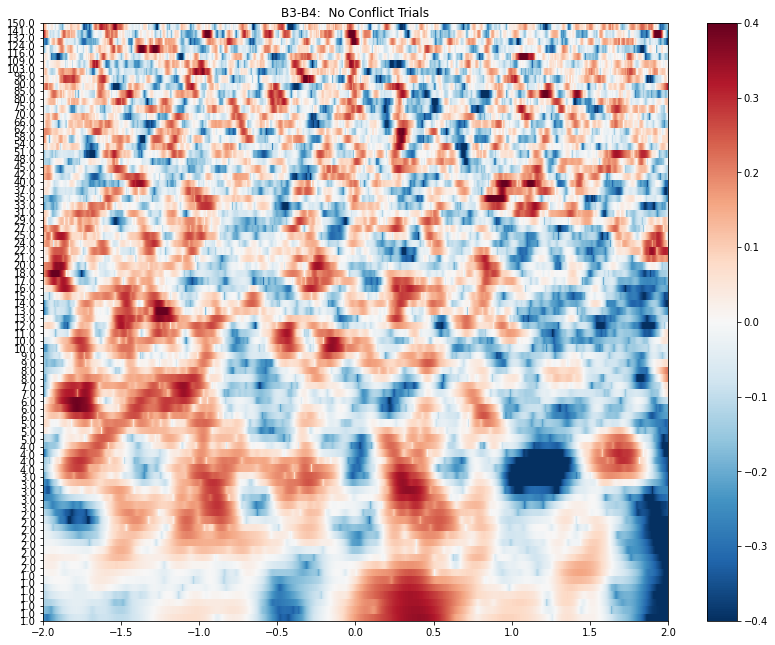

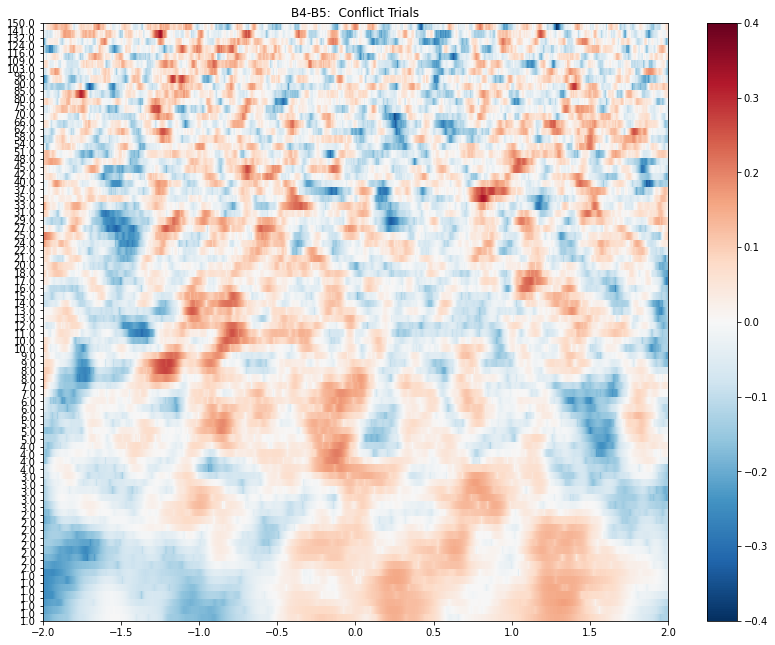

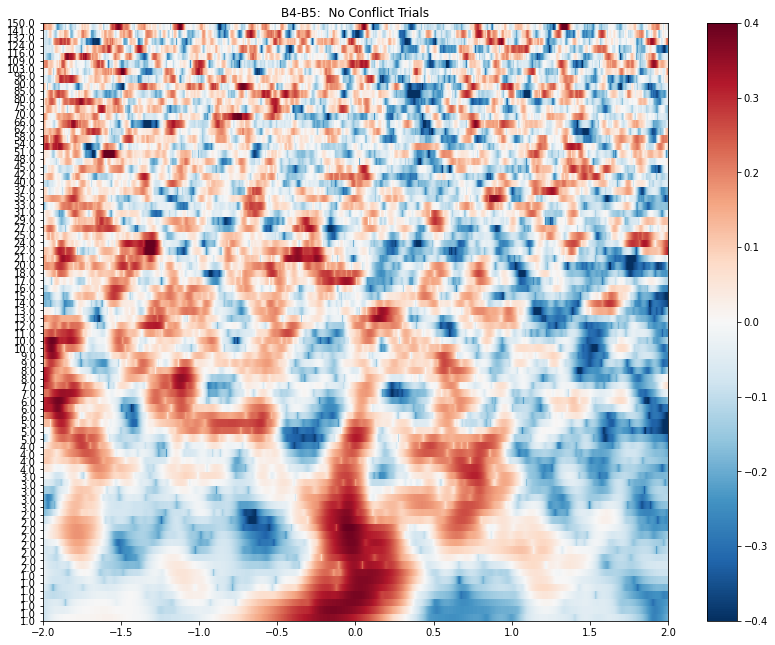

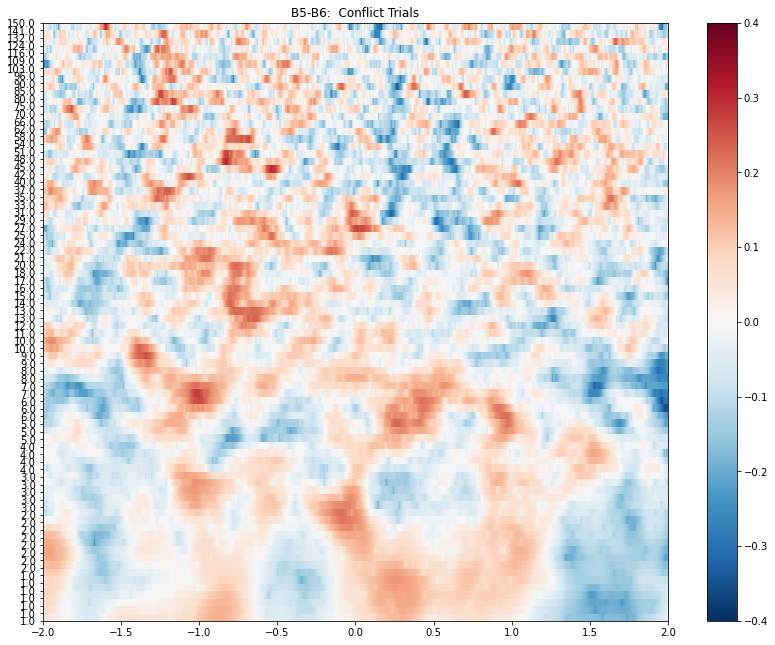

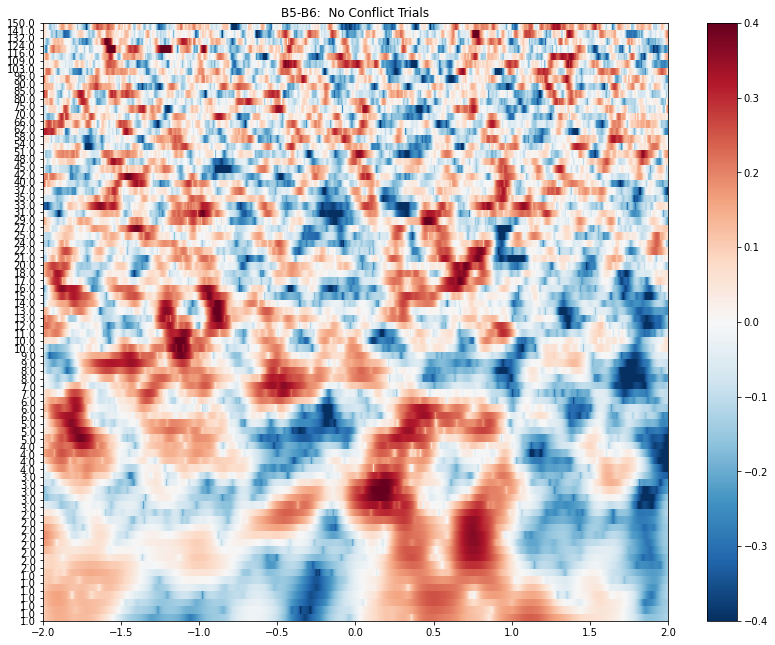

In [17]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in ghost_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Conflict Trials")
    fig.show()

    fig, ax = plt.subplots()
    i = ax.imshow(no_ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  No Conflict Trials")
    fig.show()
    
    chix = chix + 1

/tmp/ipykernel_8746/2699115855.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_8746/2699115855.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


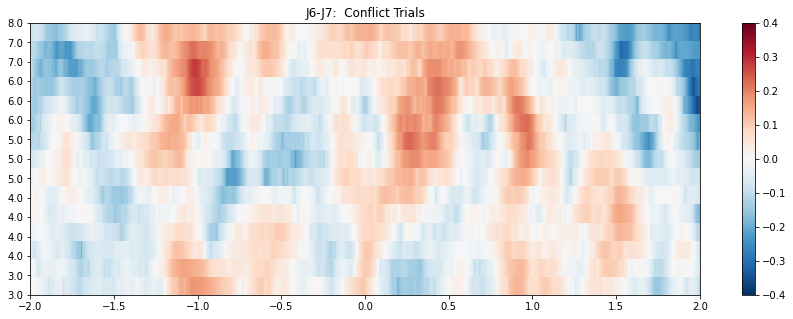

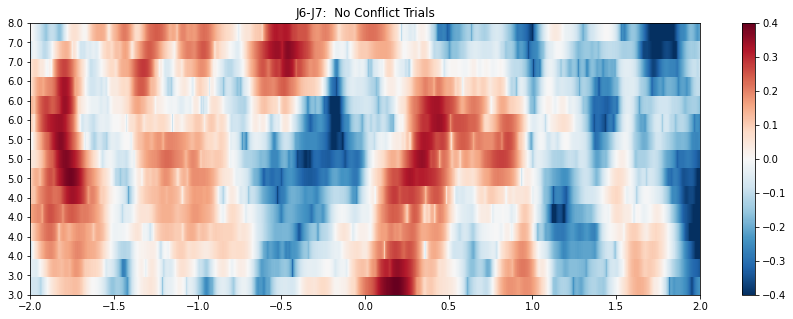

In [18]:
plt.rcParams['figure.figsize'] = [15, 5]

chix = 2
ch = 'J6-J7'
fidx = np.where((freqs > 3) & (freqs < 8))[0]
new_freqs = freqs[fidx]

fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data[:, chix, fidx, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, new_freqs[0], new_freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs[fidx]),np.max(ghost_TFR.freqs[fidx]),len(ghost_TFR.freqs[fidx])))
ax.set_yticklabels(np.round(ghost_TFR.freqs[fidx]))
bar = plt.colorbar(i)
ax.set_title(f"{ch}:  Conflict Trials")
fig.show()

fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, new_freqs[0], new_freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs[fidx]),np.max(ghost_TFR.freqs[fidx]),len(ghost_TFR.freqs[fidx])))
ax.set_yticklabels(np.round(ghost_TFR.freqs[fidx]))
bar = plt.colorbar(i)
ax.set_title(f"{ch}:  No Conflict Trials")
fig.show()


In [19]:
ghost_cis = []
no_ghost_cis = []
for theta_index in fidx:

    ghost_cis.append([1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(ghost_TFR.data[:, chix, theta_index, :])])
    no_ghost_cis.append([1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(no_ghost_TFR.data[:, chix, theta_index, :])])

ghost_ci = np.array(ghost_cis).mean(axis = 0)
no_ghost_ci = np.array(no_ghost_cis).mean(axis = 0)

In [20]:
np.transpose(no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 1)).shape

(4001, 44)

/tmp/ipykernel_8746/4284076992.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


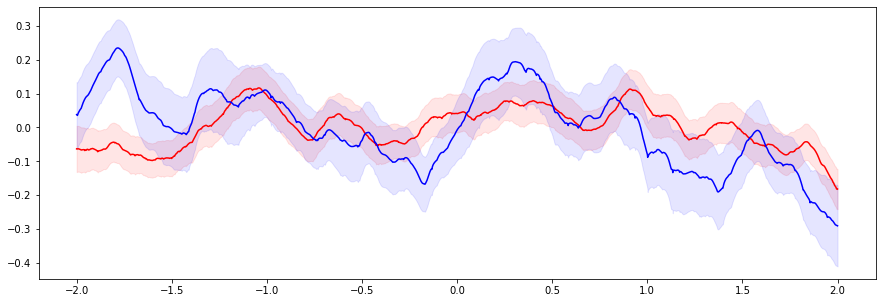

In [21]:
ghost_ci = [np.std(x)/np.sqrt(len(x)) for x in np.transpose(ghost_TFR.data[:, chix, fidx, :].mean(axis = 1))]
no_ghost_ci = [np.std(x)/np.sqrt(len(x)) for x in np.transpose(no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 1))]

y_ghost = ghost_TFR.data[:, chix, fidx, :].mean(axis = 0).mean(axis = 0)
y_no_ghost = no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 0).mean(axis = 0)

fig, ax = plt.subplots()
i = ax.plot(no_ghost_TFR.times, y_ghost, color = 'red')
ax.fill_between(no_ghost_TFR.times, (y_ghost-ghost_ci), (y_ghost + ghost_ci), color='red', alpha=.1)
i = ax.plot(no_ghost_TFR.times, y_no_ghost, color = 'blue')
ax.fill_between(no_ghost_TFR.times, (y_no_ghost-no_ghost_ci), (y_no_ghost + no_ghost_ci), color='blue', alpha=.1)

fig.show()


In [ ]:
# ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(ghost_TFR.data[:, chix, fidx, :])]
# no_ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(no_ghost_TFR.data[:, chix, fidx, :])]

y_ghost = ghost_TFR.data[:, :, fidx, :].mean(axis = 0).mean(axis = 1).mean(axis = 0)
y_no_ghost = no_ghost_TFR.data[:, :, fidx, :].mean(axis = 0).mean(axis = 1).mean(axis = 0)

fig, ax = plt.subplots()
i = ax.plot(no_ghost_TFR.times, y_ghost, color = 'red')
i = ax.plot(no_ghost_TFR.times, y_no_ghost, color = 'blue')

fig.show()

### OFC

In [ ]:
ghost_hc = ghost_epochs.copy().pick_channels(ofc_list)
no_ghost_hc = no_ghost_epochs.copy().pick_channels(ofc_list)

In [ ]:
ghost_hc= ghost_hc.resample(1000)
no_ghost_hc= no_ghost_hc.resample(1000)

In [ ]:
ghost_TFR = []
no_ghost_TFR = []

ghost_TFR = MM_compute_TFR(ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)
no_ghost_TFR = MM_compute_TFR(no_ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)

In [ ]:
ghost_TFR.crop(tmin = -2, tmax = 2)
no_ghost_TFR.crop(tmin = -2, tmax = 2)

In [ ]:
plt.rcParams['figure.figsize'] = [14, 11]
fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average OFC TFR in Conflict Trials")
fig.show()


fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average OFC TFR in No-Conflict Trials")
fig.show()

In [ ]:
# true difference matrix
true_diff_matrix = ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0) - no_ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0)


# initialize permuted matrix
permuted_matrix = np.nan * np.ones_like(true_diff_matrix)
permuted_matrices = np.repeat(permuted_matrix[np.newaxis,...], 1000, axis=0)

# get incex vectors
num_ghost_trials = ghost_TFR.data.shape[0]
num_no_ghost_trials = no_ghost_TFR.data.shape[0]
total_trials = num_ghost_trials + num_no_ghost_trials
trial_indices = np.arange(0, total_trials, 1)

# combine all tfrs
all_tfrs = np.concatenate([ghost_TFR.data[:, :, :, :] , no_ghost_TFR.data[:, :, :, :]], axis = 0)

for permute in range(0, 1000):
    
    trial_indices = np.arange(0, total_trials, 1)
    np.random.seed(permute)
    fake_ghost_indices = np.random.choice(a = trial_indices, size=num_ghost_trials, replace = False)
    fake_no_ghost_indicies = np.delete(trial_indices, fake_ghost_indices)


    fake_ghost_tfr = all_tfrs[fake_ghost_indices, :, :, :]
    fake_no_ghost_tfr = all_tfrs[fake_no_ghost_indicies, :, :, :]

    permuted_matrices[permute, :, :] = fake_ghost_tfr.mean(axis = 0).mean(axis = 0) - fake_no_ghost_tfr.mean(axis = 0).mean(axis = 0)


In [ ]:
# create dummy sig matrix
sig_matrix = np.full(true_diff_matrix.shape, False, dtype = 'bool')
pval_matrix = np.nan * np.ones_like(true_diff_matrix)


# find values at the extreme
for y in range(0,80):
    for x in range(0, 4001):

        permuted_dist = np.sort(permuted_matrices[:, y, x])

        if true_diff_matrix[y, x] <= permuted_dist[50] or true_diff_matrix[y, x] >=permuted_dist[950] :
            sig_matrix[y, x] = True
        else:
            sig_matrix[y, x] = False

sig_diff_matrix = np.where(sig_matrix, true_diff_matrix, np.nan)


In [ ]:

fig, ax = plt.subplots()
i1 = ax.imshow(true_diff_matrix, cmap = 'Greys', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
i2 = ax.imshow(sig_diff_matrix, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i2)
ax.set_title("OFC: Sig Difference Matrix")
fig.show()



In [ ]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in ghost_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Conflict Trials")
    fig.show()

    fig, ax = plt.subplots()
    i = ax.imshow(no_ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  No Conflict Trials")
    fig.show()
    
    chix = chix + 1

### Amygdala

In [ ]:
ghost_hc = ghost_epochs.copy().pick_channels(amyg_list)
no_ghost_hc = no_ghost_epochs.copy().pick_channels(amyg_list)

In [ ]:
ghost_hc= ghost_hc.resample(1000)
no_ghost_hc= no_ghost_hc.resample(1000)

In [ ]:
ghost_TFR = []
no_ghost_TFR = []

ghost_TFR = MM_compute_TFR(ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)
no_ghost_TFR = MM_compute_TFR(no_ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)

In [ ]:
ghost_TFR.crop(tmin = -2, tmax = 2)
no_ghost_TFR.crop(tmin = -2, tmax = 2)

In [ ]:
plt.rcParams['figure.figsize'] = [14, 11]
fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Amygdala TFR in Conflict Trials")
fig.show()


fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Amygdala TFR in No-Conflict Trials")
fig.show()

In [ ]:
# true difference matrix
true_diff_matrix = ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0) - no_ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0)


# initialize permuted matrix
permuted_matrix = np.nan * np.ones_like(true_diff_matrix)
permuted_matrices = np.repeat(permuted_matrix[np.newaxis,...], 1000, axis=0)

# get incex vectors
num_ghost_trials = ghost_TFR.data.shape[0]
num_no_ghost_trials = no_ghost_TFR.data.shape[0]
total_trials = num_ghost_trials + num_no_ghost_trials
trial_indices = np.arange(0, total_trials, 1)

# combine all tfrs
all_tfrs = np.concatenate([ghost_TFR.data[:, :, :, :] , no_ghost_TFR.data[:, :, :, :]], axis = 0)

for permute in range(0, 1000):
    
    trial_indices = np.arange(0, total_trials, 1)
    np.random.seed(permute)
    fake_ghost_indices = np.random.choice(a = trial_indices, size=num_ghost_trials, replace = False)
    fake_no_ghost_indicies = np.delete(trial_indices, fake_ghost_indices)


    fake_ghost_tfr = all_tfrs[fake_ghost_indices, :, :, :]
    fake_no_ghost_tfr = all_tfrs[fake_no_ghost_indicies, :, :, :]

    permuted_matrices[permute, :, :] = fake_ghost_tfr.mean(axis = 0).mean(axis = 0) - fake_no_ghost_tfr.mean(axis = 0).mean(axis = 0)


In [ ]:
# create dummy sig matrix
sig_matrix = np.full(true_diff_matrix.shape, False, dtype = 'bool')
pval_matrix = np.nan * np.ones_like(true_diff_matrix)


# find values at the extreme
for y in range(0,80):
    for x in range(0, 4001):

        permuted_dist = np.sort(permuted_matrices[:, y, x])

        if true_diff_matrix[y, x] <= permuted_dist[50] or true_diff_matrix[y, x] >=permuted_dist[950] :
            sig_matrix[y, x] = True
        else:
            sig_matrix[y, x] = False

sig_diff_matrix = np.where(sig_matrix, true_diff_matrix, np.nan)


In [ ]:

fig, ax = plt.subplots()
i1 = ax.imshow(true_diff_matrix, cmap = 'Greys', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
i2 = ax.imshow(sig_diff_matrix, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i2)
ax.set_title("Amygdala: Sig Difference Matrix")
fig.show()



In [ ]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in ghost_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Conflict Trials")
    fig.show()

    fig, ax = plt.subplots()
    i = ax.imshow(no_ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  No Conflict Trials")
    fig.show()
    
    chix = chix + 1

### Cingulate

In [ ]:
ghost_hc = ghost_epochs.copy().pick_channels(cing_list)
no_ghost_hc = no_ghost_epochs.copy().pick_channels(cing_list)

In [ ]:
ghost_hc= ghost_hc.resample(1000)
no_ghost_hc= no_ghost_hc.resample(1000)

In [ ]:
ghost_TFR = []
no_ghost_TFR = []

ghost_TFR = MM_compute_TFR(ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)
no_ghost_TFR = MM_compute_TFR(no_ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)

In [ ]:
ghost_TFR.crop(tmin = -2, tmax = 2)
no_ghost_TFR.crop(tmin = -2, tmax = 2)

In [ ]:
plt.rcParams['figure.figsize'] = [14, 11]
fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Cingulate TFR in Conflict Trials")
fig.show()
fig.savefig('BJH021_average_cingulate_conflict.png', dpi=600)

fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Cingulate TFR in No-Conflict Trials")
fig.show()
fig.savefig('BJH021_average_cingulate_noconflict.png', dpi=600)



In [ ]:
# true difference matrix
true_diff_matrix = ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0) - no_ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0)


# initialize permuted matrix
permuted_matrix = np.nan * np.ones_like(true_diff_matrix)
permuted_matrices = np.repeat(permuted_matrix[np.newaxis,...], 1000, axis=0)

# get incex vectors
num_ghost_trials = ghost_TFR.data.shape[0]
num_no_ghost_trials = no_ghost_TFR.data.shape[0]
total_trials = num_ghost_trials + num_no_ghost_trials
trial_indices = np.arange(0, total_trials, 1)

# combine all tfrs
all_tfrs = np.concatenate([ghost_TFR.data[:, :, :, :] , no_ghost_TFR.data[:, :, :, :]], axis = 0)

for permute in range(0, 1000):
    
    trial_indices = np.arange(0, total_trials, 1)
    np.random.seed(permute)
    fake_ghost_indices = np.random.choice(a = trial_indices, size=num_ghost_trials, replace = False)
    fake_no_ghost_indicies = np.delete(trial_indices, fake_ghost_indices)


    fake_ghost_tfr = all_tfrs[fake_ghost_indices, :, :, :]
    fake_no_ghost_tfr = all_tfrs[fake_no_ghost_indicies, :, :, :]

    permuted_matrices[permute, :, :] = fake_ghost_tfr.mean(axis = 0).mean(axis = 0) - fake_no_ghost_tfr.mean(axis = 0).mean(axis = 0)


In [ ]:
# create dummy sig matrix
sig_matrix = np.full(true_diff_matrix.shape, False, dtype = 'bool')
pval_matrix = np.nan * np.ones_like(true_diff_matrix)


# find values at the extreme
for y in range(0,80):
    for x in range(0, 4001):

        permuted_dist = np.sort(permuted_matrices[:, y, x])

        if true_diff_matrix[y, x] <= permuted_dist[50] or true_diff_matrix[y, x] >=permuted_dist[950] :
            sig_matrix[y, x] = True
        else:
            sig_matrix[y, x] = False

sig_diff_matrix = np.where(sig_matrix, true_diff_matrix, np.nan)


In [ ]:

fig, ax = plt.subplots()
i1 = ax.imshow(true_diff_matrix, cmap = 'Greys', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
i2 = ax.imshow(sig_diff_matrix, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i2)
ax.set_title("Cingulate: Sig Difference Matrix")
fig.show()



In [ ]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in ghost_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Conflict Trials")
    fig.show()

    fig, ax = plt.subplots()
    i = ax.imshow(no_ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  No Conflict Trials")
    fig.show()
    
    chix = chix + 1